In [66]:
from commonfunctions import *
import skimage.io as io
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as linalg
import cv2
import matplotlib.pyplot as mpplt
%matplotlib inline

In [67]:
def get_subimg(image, dims):
   return image[dims[0]:dims[1], dims[2]:dims[3]]

def poisson_blending(image):
  # comparison function
  def _compare(val1, val2):
    if(abs(val1) > abs(val2)):
      return val1
    else:
      return val2
  
  # membrane (region where Poisson blending is performed)
  mask = image['mask']
  Hs,Ws = mask.shape
  num_pxls = Hs * Ws
  
  # source and target image
  source = image['source'].flatten(order='C')
  target_subimg = get_subimg(image['target'], image['dims']).flatten(order='C')

  # initialise the mask, guidance vector field and laplacian
  # The elements are read row by row in C-style order.
  mask = mask.flatten(order='C')
  guidance_field = np.empty_like(mask)
  laplacian = sps.lil_matrix((num_pxls, num_pxls), dtype='float64')

  for i in range(num_pxls):
    # construct the sparse laplacian block matrix
    # and guidance field for the membrane
    if(mask[i] == 1):
      
      laplacian[i, i] = 4
      
      # construct laplacian, and compute source and target gradient in mask
      if(i - Ws > 0):
        laplacian[i, i-Ws] = -1
        Np_up_s = source[i] - source[i-Ws]
        Np_up_t = target_subimg[i] - target_subimg[i-Ws]
      else:
        Np_up_s = source[i]
        Np_up_t = target_subimg[i]
        
      if(i % Ws != 0):
        laplacian[i, i-1] = -1
        Np_left_s = source[i] - source[i-1]
        Np_left_t = target_subimg[i] - target_subimg[i-1]
      else:
        Np_left_s = source[i]
        Np_left_t = target_subimg[i]
        
      if(i + Ws < num_pxls):
        laplacian[i, i+Ws] = -1
        Np_down_s = source[i] - source[i+Ws]
        Np_down_t = target_subimg[i] - target_subimg[i+Ws]
      else:
        Np_down_s = source[i]
        Np_down_t = target_subimg[i]
        
      if(i % Ws != Ws-1):
        laplacian[i, i+1] = -1
        Np_right_s = source[i] - source[i+1]
        Np_right_t = target_subimg[i] - target_subimg[i+1]
      else:
        Np_right_s = source[i]
        Np_right_t = target_subimg[i]
        
      guidance_field[i] = (_compare(Np_up_s, Np_up_t) + _compare(Np_left_s, Np_left_t) + 
                           _compare(Np_down_s, Np_down_t) + _compare(Np_right_s, Np_right_t))

    else:
      # if point lies outside membrane, copy target function
      laplacian[i, i] = 1
      guidance_field[i] = target_subimg[i]
  
  return [laplacian, guidance_field]
  

In [68]:
# linear least squares solver
def linlsq_solver(A, b, dims):
  x = linalg.spsolve(A.tocsc(),b)
  return np.reshape(x,(dims[0],dims[1]))

# stitches poisson equation solution with target
def stitch_images(source, target, dims):
  target[dims[0]:dims[1], dims[2]:dims[3],:] = source
  return target

# performs poisson blending
def blend_image(image, mask, target, BLEND_TYPE):
  if(BLEND_TYPE == 2):
    equation_param = []
    ch_data = {}
    
    # construct poisson equation 
    for ch in range(3):
      ch_data['source'] = image[:,:,ch]
      ch_data['mask'] = mask[:,:,ch]
      ch_data['target'] = target[:,:,ch]
      ch_data['dims'] = [100, 100+image.shape[0], 100, 100+image.shape[1]]
      equation_param.append(poisson_blending(ch_data))

    # solve poisson equation
    image_solution = np.empty_like(image)
    for i in range(3):
      image_solution[:,:,i] = linlsq_solver(equation_param[i][0],equation_param[i][1],image.shape)
      
    image_solution = stitch_images(image_solution,target,ch_data['dims'])
    
  else:
    # wrong option
    raise Exception('Wrong option! Available: 1. Naive, 2. Poisson')
      
  return image_solution

(510, 770)
(480, 320, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


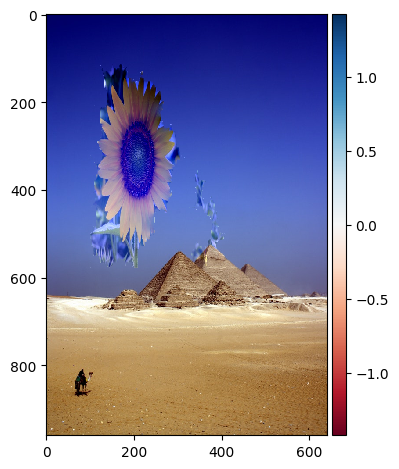

In [69]:
image = io.imread('out_Flower.jpeg')
mask = io.imread('out_Flower_mask.jpeg')
mask3 = np.zeros_like(image)

print(mask.shape)
mask3[:,:,0] = mask
mask3[:,:,1] = mask
mask3[:,:,2] = mask
target = io.imread('./Test_Images/pyramids.jpeg')

image = cv2.resize(image, (target.shape[1] // 2, target.shape[0] // 2))
mask3 = cv2.resize(mask3, (target.shape[1] // 2, target.shape[0] // 2))

print(mask3.shape)

image = image / 255.0
mask3 = mask3 / 255.0
target = target / 255.0

final_image = blend_image(image, mask3, target, 2) # blend the image
io.imshow(final_image)
io.show()


In [70]:
# # final_image = np.zeros_like(target)
# mask = np.ones_like(image, dtype=np.uint8)

# final_image = cv2.seamlessClone(image, target, mask, (20,20), cv2.NORMAL_CLONE)

# io.imshow(final_image)
# io.show()